In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics.classification import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from textvec import vectorizers

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load data

## IMDB

In [3]:
def get_binary_imdb_data(base_dir, num_files=5000):
    def get_df(corpus_type):
        texts = []
        y = []
        corpus_type_dir = os.path.join(base_dir, f'{corpus_type}/pos/')
        for i, f_name in enumerate(os.listdir(corpus_type_dir)):
            if i == num_files: break
            f_path = os.path.join(corpus_type_dir, f_name)
            with open(f_path) as f:
                texts.append(f.read())
                y.append(1)
        corpus_type_dir = os.path.join(base_dir, f'{corpus_type}/neg/')
        for i, f_name in enumerate(os.listdir(corpus_type_dir)):
            if i == num_files: break
            f_path = os.path.join(corpus_type_dir, f_name)
            with open(f_path) as f:
                texts.append(f.read())
                y.append(0)
        df = pd.DataFrame()
        df['y'] = y
        df['text'] = texts
        return df
    train_data = shuffle(get_df('train'), random_state=0)
    test_data = shuffle(get_df('test'), random_state=0)
    return train_data, test_data

In [4]:
imdb_train, imdb_test = get_binary_imdb_data("data/aclImdb", num_files=None)

## Rotten tomatoes

In [5]:
def get_binary_RT_data(base_dir):
    texts = []
    y = []
    f_path = os.path.join(base_dir, "rt-polarity.pos")
    with open(f_path, encoding = "ISO-8859-1") as f:
        for text in f:
            texts.append(text)
            y.append(1)
    f_path = os.path.join(base_dir, "rt-polarity.neg")
    with open(f_path, encoding = "ISO-8859-1") as f:
        for text in f:
            texts.append(text)
            y.append(0)
    X_train, X_test, y_train, y_test = train_test_split(
        texts, y, stratify=y, test_size=0.2, random_state=0
    )
    train_data = pd.DataFrame({"text": X_train, "y": y_train})
    test_data = pd.DataFrame({"text": X_test, "y": y_test})
    return train_data, test_data

In [6]:
rt_train, rt_test = get_binary_RT_data("data/rt-polaritydata")

## Airline sentiment

In [7]:
def get_airline_binary_sentiment_data(path):
    df = pd.read_csv(path, encoding = "ISO-8859-1")
    df = df[df.airline_sentiment.isin(["negative","positive"])]
    df.loc[df.airline_sentiment == "negative","airline_sentiment"] = 0
    df.loc[df.airline_sentiment == "positive","airline_sentiment"] = 1
    X_train, X_test, y_train, y_test = train_test_split(
        df.text, df.airline_sentiment, stratify=df.airline_sentiment, test_size=0.2, random_state=0
    )
    train_data = pd.DataFrame({"text": X_train, "y": y_train})
    test_data = pd.DataFrame({"text": X_test, "y": y_test})
    return train_data, test_data

In [8]:
air_train, air_test = get_airline_binary_sentiment_data("data/Airline-Sentiment-2-w-AA.csv")

# Grid search

In [9]:
transformers = [
    ("tf", TfidfTransformer(use_idf=False, sublinear_tf=True)),
    ("tfidf", TfidfTransformer(sublinear_tf=True)),
    ("tfpf", vectorizers.TfpfVectorizer(sublinear_tf=True)),
    ("tfrf", vectorizers.TfrfVectorizer(sublinear_tf=True)),
    ("tficf", vectorizers.TfIcfVectorizer(sublinear_tf=True)),
    ("tfbinicf", vectorizers.TfBinIcfVectorizer(sublinear_tf=True)),
    ("tfchi2", vectorizers.Tfchi2Vectorizer(sublinear_tf=True)),
    ("tfgr", vectorizers.TfgrVectorizer(sublinear_tf=True)),
    ("tfrrf", vectorizers.TfrrfVectorizer(sublinear_tf=True)),
    ("tfor", vectorizers.TforVectorizer(sublinear_tf=True))
]

In [10]:
param_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "vectorizer__max_features": [2000, 5000, None],
    "clf__C": [0.01, 0.1, 1, 10],
}

In [11]:
def grid_search(param_grid, train, test, n_jobs=-1):
    results = dict()
    
    for name, transformer in transformers:
        pipeline = Pipeline([
            ("vectorizer", CountVectorizer()),
            ("transformer", transformer),
            ("clf", LogisticRegression(solver="saga", random_state=0))
        ])
        search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=n_jobs, scoring="accuracy")
        search.fit(train.text, train.y)

        test_preds_proba = search.best_estimator_.predict_proba(test.text)
        test_preds = np.argmax(test_preds_proba, axis=1)

        train_accuracy = search.best_score_
        test_accuracy = accuracy_score(test.y, test_preds)
        f1 = f1_score(test.y, test_preds)
        print(f"{name:10} train accuracy: {train_accuracy:<15} test accuracy: {test_accuracy}")

        local_results = {
            "best_params": search.best_params_,
            "test_accuracy": test_accuracy,
            "f1": f1,
            "preds_proba": test_preds_proba[:, 1]
        }
        results[name] = local_results
    return results

# Correlation heatmap

In [12]:
def plot_correlation_heatmap(results, title):
    probs = []
    labels = []
    for name, _ in transformers:
        probs.append(results[name]["preds_proba"])
        accuracy = results[name]["test_accuracy"]
        labels.append(f"{name}: {accuracy:.4f}")
    probs = np.array(probs)
    corr = np.corrcoef(probs)

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(corr, 
                     cmap="viridis", 
                     square=True, 
                     annot=corr, 
                     linewidth=0.5,
                     xticklabels=labels,
                     yticklabels=labels)
    ax.set_title(title)
    plt.show()

tf         train accuracy: 0.7624574979481769 test accuracy: 0.757149554617909
tfidf      train accuracy: 0.7707820377535467 test accuracy: 0.7716830754805438
tfpf       train accuracy: 0.7507327939969516 test accuracy: 0.7402719174871074
tfrf       train accuracy: 0.7512017821550006 test accuracy: 0.7412095639943741
tficf      train accuracy: 0.7714855199906202 test accuracy: 0.7641819034224098
tfbinicf   train accuracy: 0.7624574979481769 test accuracy: 0.757149554617909
tfchi2     train accuracy: 0.7378356196506038 test accuracy: 0.739803094233474
tfgr       train accuracy: 0.711924023918396 test accuracy: 0.706516643225504
tfrrf      train accuracy: 0.7598780630789073 test accuracy: 0.7505860290670417
tfor       train accuracy: 0.7747684370969633 test accuracy: 0.7805907172995781


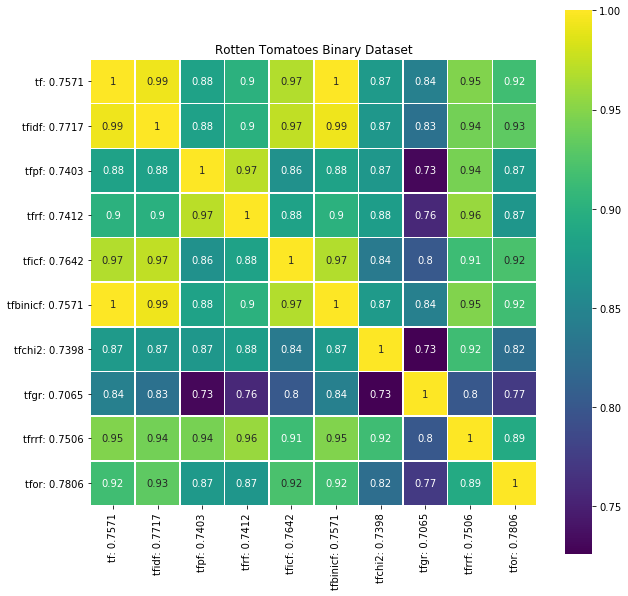

In [13]:
results = grid_search(param_grid, rt_train, rt_test, n_jobs=7)
plot_correlation_heatmap(results, "Rotten Tomatoes Binary Dataset")

tf         train accuracy: 0.89492         test accuracy: 0.8984
tfidf      train accuracy: 0.90496         test accuracy: 0.9052
tfpf       train accuracy: 0.89012         test accuracy: 0.88136
tfrf       train accuracy: 0.88764         test accuracy: 0.87972
tficf      train accuracy: 0.89652         test accuracy: 0.89844
tfbinicf   train accuracy: 0.89492         test accuracy: 0.8984
tfchi2     train accuracy: 0.88956         test accuracy: 0.88984
tfgr       train accuracy: 0.87604         test accuracy: 0.88496
tfrrf      train accuracy: 0.88512         test accuracy: 0.88788
tfor       train accuracy: 0.91164         test accuracy: 0.90924


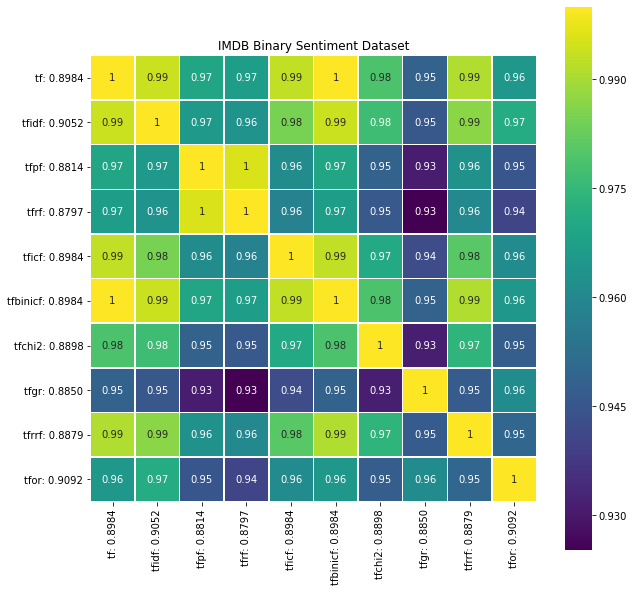

In [14]:
results = grid_search(param_grid, imdb_train, imdb_test, n_jobs=4)
plot_correlation_heatmap(results, "IMDB Binary Sentiment Dataset")

tf         train accuracy: 0.9221187175043327 test accuracy: 0.9194456474664356
tfidf      train accuracy: 0.9243934142114385 test accuracy: 0.9259419662191425
tfpf       train accuracy: 0.9226603119584056 test accuracy: 0.9211779991338241
tfrf       train accuracy: 0.9219020797227037 test accuracy: 0.9194456474664356
tficf      train accuracy: 0.9236351819757366 test accuracy: 0.9198787353832828
tfbinicf   train accuracy: 0.9221187175043327 test accuracy: 0.9194456474664356
tfchi2     train accuracy: 0.9129116117850953 test accuracy: 0.9107838891294933
tfgr       train accuracy: 0.8996967071057193 test accuracy: 0.895625812039844
tfrrf      train accuracy: 0.9222270363951474 test accuracy: 0.9194456474664356
tfor       train accuracy: 0.9246100519930676 test accuracy: 0.920744911216977


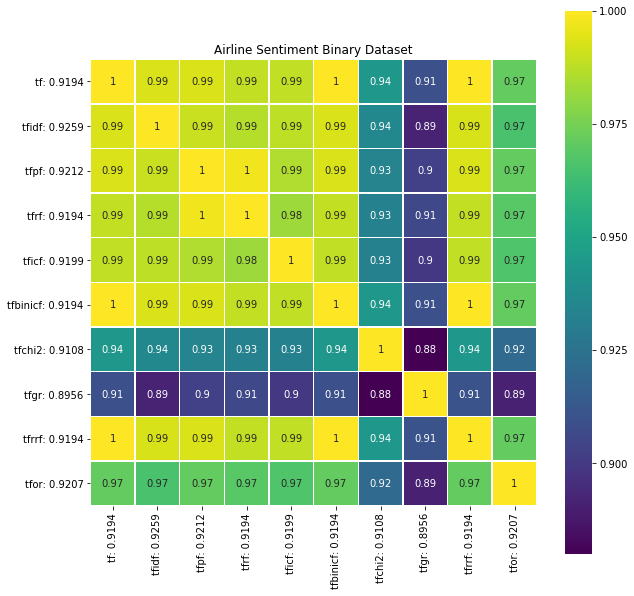

In [15]:
results = grid_search(param_grid, air_train, air_test, n_jobs=7)
plot_correlation_heatmap(results, "Airline Sentiment Binary Dataset")